In [29]:
import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
API_KEY = "33c3009d4610d7c8a3484f3bc865055b"          
BASE_URL = "https://api.themoviedb.org/3"

# The 19 IDs given in the lab (0 is invalid → we remove it)
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818,
    24428, 168259, 99861, 284054, 12445, 181808, 330457,
    351286, 109445, 321612, 260513
    # 0 was removed because TMDb has no movie with ID 0 → it returns 404
]

# === 2. Function to get one movie (with credits appended) ===
def fetch_movie(movie_id: int) -> dict:
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {
        "api_key": API_KEY,
        "language": "en-US",
        "append_to_response": "credits"   # gets cast + crew in the same call
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    elif response.status_code == 404:
        print(f"Movie ID {movie_id} not found (404)")
        return None
    else:
        print(f"Error {response.status_code} for ID {movie_id}: {response.text}")
        return None
    
 

In [3]:

# === 3. Fetch all movies with polite delay (TMDb allows ~50 requests/sec, but we play nice) ===
print("Starting to fetch movies...")
raw_movies_data = []

for idx, mid in enumerate(movie_ids, 1):
    print(f"  [{idx:02d}/{len(movie_ids)}] Fetching ID {mid}...", end=" ")
    movie = fetch_movie(mid)
    if movie:
        raw_movies_data.append(movie)
        print("Success")
    else:
        print("Failed")
    
    time.sleep(0.22)  # ~4–5 requests per second → stays far below rate limit

print(f"\nFinished! Successfully fetched {len(raw_movies_data)} movies.")


Starting to fetch movies...
  [01/19] Fetching ID 0... Movie ID 0 not found (404)
Failed
  [02/19] Fetching ID 299534... Success
  [03/19] Fetching ID 19995... Success
  [04/19] Fetching ID 140607... Success
  [05/19] Fetching ID 299536... Success
  [06/19] Fetching ID 597... Success
  [07/19] Fetching ID 135397... Success
  [08/19] Fetching ID 420818... Success
  [09/19] Fetching ID 24428... Success
  [10/19] Fetching ID 168259... Success
  [11/19] Fetching ID 99861... Success
  [12/19] Fetching ID 284054... Success
  [13/19] Fetching ID 12445... Success
  [14/19] Fetching ID 181808... Success
  [15/19] Fetching ID 330457... Success
  [16/19] Fetching ID 351286... Success
  [17/19] Fetching ID 109445... Success
  [18/19] Fetching ID 321612... Success
  [19/19] Fetching ID 260513... Success

Finished! Successfully fetched 18 movies.


In [4]:
# === 4. Convert the list of JSONs into a Pandas DataFrame ===
df_raw = pd.DataFrame(raw_movies_data)


print(f"\nDataFrame shape: {df_raw.shape}")
print("Columns:", list(df_raw.columns))
print("\nFirst 2 rows sample:")
display(df_raw[['id', 'title', 'release_date', 'budget', 'revenue']].head(10))


df_raw.to_json("raw_tmdb_movies.json", orient="records", indent=2)

print("\nRaw data saved as raw_tmdb_movies.json and .csv")


DataFrame shape: (18, 27)
Columns: ['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'origin_country', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'credits']

First 2 rows sample:


,id,title,release_date,budget,revenue
0,299534,Avengers: Endgame,2019-04-24,356000000,2799439100
1,19995,Avatar,2009-12-15,237000000,2923706026
2,140607,Star Wars: The Force Awakens,2015-12-15,245000000,2068223624
3,299536,Avengers: Infinity War,2018-04-25,300000000,2052415039
4,597,Titanic,1997-11-18,200000000,2264162353
5,135397,Jurassic World,2015-06-06,150000000,1671537444
6,420818,The Lion King,2019-07-12,260000000,1662020819
7,24428,The Avengers,2012-04-25,220000000,1518815515
8,168259,Furious 7,2015-04-01,190000000,1515400000
9,99861,Avengers: Age of Ultron,2015-04-22,235000000,1405403694



Raw data saved as raw_tmdb_movies.json and .csv


In [5]:
df_raw.info()
print(f"Original shape: {df_raw.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18 non-null     bool   
 1   backdrop_path          18 non-null     object 
 2   belongs_to_collection  16 non-null     object 
 3   budget                 18 non-null     int64  
 4   genres                 18 non-null     object 
 5   homepage               18 non-null     object 
 6   id                     18 non-null     int64  
 7   imdb_id                18 non-null     object 
 8   origin_country         18 non-null     object 
 9   original_language      18 non-null     object 
 10  original_title         18 non-null     object 
 11  overview               18 non-null     object 
 12  popularity             18 non-null     float64
 13  poster_path            18 non-null     object 
 14  production_companies   18 non-null     object 
 15  producti

##### STEP 2 – DATA CLEANING(PHASE 1)

In [6]:
df_clean = df_raw.copy()
print(f"Starting with shape: {df_clean.shape}")

Starting with shape: (18, 27)


In [7]:
# === 1. Drop irrelevant columns ===
drop_cols = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
df_clean = df_clean.drop(columns=[col for col in drop_cols if col in df_clean.columns])
print(f"After dropping columns: {df_clean.shape}")


# === 2. Helper functions ===
def extract_collection_name(collection):
    if isinstance(collection, dict) and 'name' in collection:
        return collection['name']
    return np.nan

def extract_genres(genres_list):
    if isinstance(genres_list, list) and len(genres_list) > 0:
        return '|'.join([genre['name'] for genre in genres_list if 'name' in genre])
    return np.nan

def extract_spoken_languages(languages_list):
    if isinstance(languages_list, list) and len(languages_list) > 0:
        return '|'.join([lang['name'] for lang in languages_list if 'name' in lang])
    return np.nan

def extract_production_countries(countries_list):
    if isinstance(countries_list, list) and len(countries_list) > 0:
        return '|'.join([country['name'] for country in countries_list if 'name' in country])
    return np.nan

def extract_production_companies(companies_list):
    if isinstance(companies_list, list) and len(companies_list) > 0:
        return '|'.join([company['name'] for company in companies_list if 'name' in company])
    return np.nan

def extract_cast(credits):
    """Extract top cast members as 'Actor1|Actor2|...' or NaN."""
    if isinstance(credits, dict) and 'cast' in credits:
        cast_list = credits['cast'][:5]  # Top 5 actors
        return '|'.join([actor['name'] for actor in cast_list if 'name' in actor])
    return np.nan

def extract_cast_size(credits):
    if isinstance(credits, dict) and 'cast' in credits:
        return len(credits['cast'])
    return np.nan

def extract_crew_size(credits):
    if isinstance(credits, dict) and 'crew' in credits:
        return len(credits['crew'])
    return np.nan

def extract_director(credits):
    if isinstance(credits, dict) and 'crew' in credits:
        for person in credits['crew']:
            if person.get('job') == 'Director':
                return person.get('name', 'Unknown')
    return 'Unknown'

After dropping columns: (18, 22)


In [8]:
# === 3. Extract to TEMPORARY columns (different names) ===
print("\nExtracting nested fields...")

df_clean['collection_name'] = df_clean['belongs_to_collection'].apply(extract_collection_name)
df_clean['genre_names'] = df_clean['genres'].apply(extract_genres)
df_clean['language_codes'] = df_clean['spoken_languages'].apply(extract_spoken_languages)
df_clean['country_names'] = df_clean['production_countries'].apply(extract_production_countries)
df_clean['company_names'] = df_clean['production_companies'].apply(extract_production_companies)

# Extract from credits BEFORE dropping it
df_clean['cast'] = df_clean['credits'].apply(extract_cast)
df_clean['cast_size'] = df_clean['credits'].apply(extract_cast_size)
df_clean['crew_size'] = df_clean['credits'].apply(extract_crew_size)
df_clean['director'] = df_clean['credits'].apply(extract_director)

# === 4. NOW drop the raw JSON columns ===
json_cols = ['belongs_to_collection', 'genres', 'production_countries', 
             'production_companies', 'spoken_languages', 'credits']
df_clean = df_clean.drop(columns=[col for col in json_cols if col in df_clean.columns])

# === 5. Rename extracted columns to match required names ===
df_clean = df_clean.rename(columns={
    'genre_names': 'genres',
    'language_codes': 'spoken_languages',
    'country_names': 'production_countries',
    'company_names': 'production_companies'
})


Extracting nested fields...


### STEP 2 (PHASE 2) HANDLING MISSING DATA 

In [ ]:
# === 6. Inspect extracted columns ===
print("\n=== INSPECTION: Value Counts ===")
inspection_cols = ['collection_name', 'genres', 'spoken_languages', 
                   'production_countries', 'production_companies']

for col in inspection_cols:
    if col in df_clean.columns:
        print(f"\n{col.upper()}:")
        print(df_clean[col].value_counts().head(5))
        print(f"  → Unique: {df_clean[col].nunique()}, NaNs: {df_clean[col].isna().sum()}")





=== INSPECTION: Value Counts ===

COLLECTION_NAME:
collection_name
The Avengers Collection     4
Star Wars Collection        2
Frozen Collection           2
Jurassic Park Collection    2
Avatar Collection           1
Name: count, dtype: int64
  → Unique: 10, NaNs: 2

GENRES:
genres
Adventure|Action|Science Fiction             3
Action|Adventure|Science Fiction|Thriller    2
Action|Adventure|Science Fiction             2
Action|Adventure|Fantasy|Science Fiction     1
Drama|Romance                                1
Name: count, dtype: int64
  → Unique: 14, NaNs: 0

SPOKEN_LANGUAGES:
spoken_languages
English                                              9
English|日本語|                                         1
English|Español                                      1
English|                                             1
English|Français|Deutsch|svenska|Italiano|Pусский    1
Name: count, dtype: int64
  → Unique: 10, NaNs: 0

PRODUCTION_COUNTRIES:
production_countries
United States of America  

In [25]:
print("Converting datatypes...")

# Numeric columns - force conversion, invalid → NaN
df_clean['budget'] = pd.to_numeric(df_clean['budget'], errors='coerce')
df_clean['revenue'] = pd.to_numeric(df_clean['revenue'], errors='coerce')
df_clean['id'] = pd.to_numeric(df_clean['id'], errors='coerce')
df_clean['popularity'] = pd.to_numeric(df_clean['popularity'], errors='coerce')
df_clean['vote_count'] = pd.to_numeric(df_clean['vote_count'], errors='coerce')
df_clean['vote_average'] = pd.to_numeric(df_clean['vote_average'], errors='coerce')
df_clean['runtime'] = pd.to_numeric(df_clean['runtime'], errors='coerce')

# Convert release_date to datetime
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')

print(f"  ✓ Converted budget, revenue, id, popularity, vote_count, vote_average, runtime to numeric")
print(f"  ✓ Converted release_date to datetime")

# === 6. REPLACE UNREALISTIC VALUES ===
print("\nReplacing unrealistic values...")

# Budget/Revenue/Runtime = 0 → Replace with NaN
zero_budget_count = (df_clean['budget'] == 0).sum()
zero_revenue_count = (df_clean['revenue'] == 0).sum()
zero_runtime_count = (df_clean['runtime'] == 0).sum()

df_clean['budget'] = df_clean['budget'].replace(0, np.nan)
df_clean['revenue'] = df_clean['revenue'].replace(0, np.nan)
df_clean['runtime'] = df_clean['runtime'].replace(0, np.nan)

print(f"  ✓ Replaced {zero_budget_count} zero budgets with NaN")
print(f"  ✓ Replaced {zero_revenue_count} zero revenues with NaN")
print(f"  ✓ Replaced {zero_runtime_count} zero runtimes with NaN")

# Convert budget and revenue to millions USD
df_clean['budget_musd'] = df_clean['budget'] / 1_000_000
df_clean['revenue_musd'] = df_clean['revenue'] / 1_000_000

print(f"  ✓ Converted budget and revenue to millions USD")
print(f"    - Budget range: ${df_clean['budget_musd'].min():.2f}M to ${df_clean['budget_musd'].max():.2f}M")
print(f"    - Revenue range: ${df_clean['revenue_musd'].min():.2f}M to ${df_clean['revenue_musd'].max():.2f}M")

# vote_count == 0 → vote_average is unreliable
df_clean.loc[df_clean['vote_count'] == 0, 'vote_average'] = np.nan

# Clean overview and tagline
df_clean['overview'] = df_clean['overview'].replace(['', 'No overview found.', 'No Overview'], np.nan)
df_clean['tagline'] = df_clean['tagline'].replace(['', 'No tagline.'], np.nan)


Converting datatypes...
  ✓ Converted budget, revenue, id, popularity, vote_count, vote_average, runtime to numeric
  ✓ Converted release_date to datetime

Replacing unrealistic values...
  ✓ Replaced 0 zero budgets with NaN
  ✓ Replaced 0 zero revenues with NaN
  ✓ Replaced 0 zero runtimes with NaN
  ✓ Converted budget and revenue to millions USD
    - Budget range: $125.00M to $356.00M
    - Revenue range: $1243.23M to $2923.71M


In [26]:
print("\n=== Sample of cleaned data ===")
df_clean.head(3)



=== Sample of cleaned data ===


,backdrop_path,budget,id,origin_country,original_language,overview,popularity,poster_path,release_date,revenue,...,genres,spoken_languages,production_countries,production_companies,cast,cast_size,crew_size,director,budget_musd,revenue_musd
0,/9wXPKruA6bWYk2co5ix6fH59Qr8.jpg,356000000,299534,[US],en,After the devastating events of Avengers: Infi...,14.7068,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,2019-04-24,2799439100,...,Adventure|Science Fiction|Action,English|日本語|,United States of America,Marvel Studios,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,105,607,Joe Russo,356.0,2799.439100
1,/7JNzw1tSZZEgsBw6lu0VfO2X2Ef.jpg,237000000,19995,[US],en,"In the 22nd century, a paraplegic Marine is di...",39.5744,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,2009-12-15,2923706026,...,Action|Adventure|Fantasy|Science Fiction,English|Español,United States of America|United Kingdom,Dune Entertainment|Lightstorm Entertainment|20...,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,65,990,James Cameron,237.0,2923.706026
2,/8BTsTfln4jlQrLXUBquXJ0ASQy9.jpg,245000000,140607,[US],en,Thirty years after defeating the Galactic Empi...,8.6150,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,2015-12-15,2068223624,...,Adventure|Action|Science Fiction,English,United States of America,Lucasfilm Ltd.|Bad Robot,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,262,J.J. Abrams,245.0,2068.223624


In [31]:
# 7. Drop duplicates + critical missing
df_clean = df_clean.drop_duplicates(subset='id')
df_clean = df_clean.dropna(subset=['id', 'title'])

# 8. Keep only rows with meaningful data (at least 10 non-null columns)
df_clean = df_clean.dropna(thresh=10)

# 9. Keep only Released movies
if 'status' in df_clean.columns:
    df_clean = df_clean[df_clean['status'] == 'Released']
    df_clean = df_clean.drop(columns='status')

# 10. FINAL COLUMN ORDER
final_column_order = [
    'id', 'title', 'tagline', 'release_date', 'genres', 'collection_name',
    'original_language', 'budget_musd', 'revenue_musd',
    'production_companies', 'production_countries',
    'vote_count', 'vote_average', 'popularity', 'runtime',
    'overview', 'spoken_languages', 'poster_path',
    'cast', 'cast_size', 'director', 'crew_size'
]


# Reindex to match required order (only existing columns)
existing_cols = [col for col in final_column_order if col in df_clean.columns]
df_final = df_clean[existing_cols].copy()

# 11. Reset index
df_final = df_final.reset_index(drop=True)
print(f"\nFinal cleaned DataFrame shape: {df_final.shape}")


Final cleaned DataFrame shape: (18, 22)


In [28]:
df_final.info(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    18 non-null     int64         
 1   title                 18 non-null     object        
 2   tagline               18 non-null     object        
 3   release_date          18 non-null     datetime64[ns]
 4   genres                18 non-null     object        
 5   collection_name       16 non-null     object        
 6   original_language     18 non-null     object        
 7   budget_musd           18 non-null     float64       
 8   revenue_musd          18 non-null     float64       
 9   production_companies  18 non-null     object        
 10  production_countries  18 non-null     object        
 11  vote_count            18 non-null     int64         
 12  vote_average          18 non-null     float64       
 13  popularity            

### Step 3: KPI Implementation & Analysis


In [32]:
# Calculate derived metrics
df_final['profit_musd'] = df_final['revenue_musd'] - df_final['budget_musd']
df_final['roi'] = df_final['revenue_musd'] / df_final['budget_musd']


In [33]:
# === 2. Define User-Defined Function (UDF) for Ranking ===
def get_top_movies(df, metric, top_n=5, ascending=False, filter_condition=None, 
                   display_cols=None):
    """
    Universal function to rank and display top/bottom movies by any metric.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    metric : str
        Column name to rank by
    top_n : int
        Number of results to return
    ascending : bool
        False for highest (default), True for lowest
    filter_condition : Series or None
        Boolean mask to filter dataframe before ranking
    display_cols : list or None
        Columns to display in output
        
    Returns:
    --------
    DataFrame : Top N ranked movies
    """
    if display_cols is None:
        display_cols = ['title', metric, 'release_date', 'genres']
    
    # Apply filter if provided
    if filter_condition is not None:
        df_filtered = df[filter_condition].copy()
    else:
        df_filtered = df.copy()
    
    # Remove rows where metric is NaN
    df_filtered = df_filtered.dropna(subset=[metric])
    
    # Sort and return top N
    result = df_filtered.nlargest(top_n, metric) if not ascending else df_filtered.nsmallest(top_n, metric)
    
    return result[display_cols]


In [34]:
# === 1. Run All Rankings ===

print("\n HIGHEST REVENUE MOVIES")
print("-" * 80)
result = get_top_movies(df_final, 'revenue_musd', top_n=5, 
                        display_cols=['title', 'revenue_musd', 'budget_musd', 'genres'])
print(result.to_string(index=False))

print("\n HIGHEST BUDGET MOVIES")
print("-" * 80)
result = get_top_movies(df_final, 'budget_musd', top_n=5,
                        display_cols=['title', 'budget_musd', 'revenue_musd', 'release_date'])
print(result.to_string(index=False))

print("\n HIGHEST PROFIT MOVIES")
print("-" * 80)
result = get_top_movies(df_final, 'profit_musd', top_n=5,
                        display_cols=['title', 'profit_musd', 'revenue_musd', 'budget_musd'])
print(result.to_string(index=False))

print("\n LOWEST PROFIT MOVIES (Biggest Losses)")
print("-" * 80)
result = get_top_movies(df_final, 'profit_musd', top_n=5, ascending=True,
                        display_cols=['title', 'profit_musd', 'revenue_musd', 'budget_musd'])
print(result.to_string(index=False))

print("\n HIGHEST ROI MOVIES (Budget ≥ $10M)")
print("-" * 80)
result = get_top_movies(df_final, 'roi', top_n=5, 
                        filter_condition=(df_final['budget_musd'] >= 10),
                        display_cols=['title', 'roi', 'revenue_musd', 'budget_musd'])
print(result.to_string(index=False))

print("\n LOWEST ROI MOVIES (Budget ≥ $10M)")
print("-" * 80)
result = get_top_movies(df_final, 'roi', top_n=5, ascending=True,
                        filter_condition=(df_final['budget_musd'] >= 10),
                        display_cols=['title', 'roi', 'revenue_musd', 'budget_musd'])
print(result.to_string(index=False))

print("\n MOST VOTED MOVIES")
print("-" * 80)
result = get_top_movies(df_final, 'vote_count', top_n=5,
                        display_cols=['title', 'vote_count', 'vote_average', 'popularity'])
print(result.to_string(index=False))

print("\n HIGHEST RATED MOVIES (≥ 10 votes)")
print("-" * 80)
result = get_top_movies(df_final, 'vote_average', top_n=5,
                        filter_condition=(df_final['vote_count'] >= 10),
                        display_cols=['title', 'vote_average', 'vote_count', 'genres'])
print(result.to_string(index=False))

print("\n LOWEST RATED MOVIES (≥ 10 votes)")
print("-" * 80)
result = get_top_movies(df_final, 'vote_average', top_n=5, ascending=True,
                        filter_condition=(df_final['vote_count'] >= 10),
                        display_cols=['title', 'vote_average', 'vote_count', 'genres'])
print(result.to_string(index=False))

print("\n MOST POPULAR MOVIES")
print("-" * 80)
result = get_top_movies(df_final, 'popularity', top_n=5,
                        display_cols=['title', 'popularity', 'vote_average', 'release_date'])
print(result.to_string(index=False))


# ========================================
# PART 2: ADVANCED MOVIE FILTERING & SEARCH QUERIES
# ========================================

print("\n\n" + "="*80)
print("PART 2: ADVANCED MOVIE FILTERING & SEARCH QUERIES")
print("="*80)

# === Search 1: Best-rated Sci-Fi Action movies with Bruce Willis ===
print("\n SEARCH 1: Best-rated Science Fiction Action movies starring Bruce Willis")
print("-" * 80)

# Filter conditions
search1 = df_final[
    (df_final['genres'].str.contains('Science Fiction', case=False, na=False)) &
    (df_final['genres'].str.contains('Action', case=False, na=False)) &
    (df_final['cast'].str.contains('Bruce Willis', case=False, na=False))
].copy()

# Sort by rating (highest to lowest)
search1 = search1.sort_values('vote_average', ascending=False)

if len(search1) > 0:
    print(search1[['title', 'vote_average', 'vote_count', 'genres', 'cast']].to_string(index=False))
else:
    print(" No movies found matching criteria")


# === Search 2: Uma Thurman movies directed by Quentin Tarantino ===
print("\n SEARCH 2: Movies starring Uma Thurman, directed by Quentin Tarantino")
print("-" * 80)

search2 = df_final[
    (df_final['cast'].str.contains('Uma Thurman', case=False, na=False)) &
    (df_final['director'].str.contains('Quentin Tarantino', case=False, na=False))
].copy()

# Sort by runtime (shortest to longest)
search2 = search2.sort_values('runtime', ascending=True)

if len(search2) > 0:
    print(search2[['title', 'runtime', 'director', 'cast', 'release_date']].to_string(index=False))
else:
    print(" No movies found matching criteria")


# ========================================
# PART 3: FRANCHISE VS STANDALONE MOVIE PERFORMANCE
# ========================================

print("\n\n" + "="*80)
print("PART 3: FRANCHISE VS STANDALONE MOVIE PERFORMANCE")
print("="*80)

# Create franchise indicator
df_final['is_franchise'] = df_final['collection_name'].notna()

# Split into franchise and standalone
franchise_movies = df_final[df_final['is_franchise'] == True]
standalone_movies = df_final[df_final['is_franchise'] == False]

# Calculate comparison metrics
comparison_data = {
    'Metric': ['Mean Revenue (M USD)', 'Median ROI', 'Mean Budget (M USD)', 
               'Mean Popularity', 'Mean Rating'],
    'Franchise Movies': [
        franchise_movies['revenue_musd'].mean(),
        franchise_movies['roi'].median(),
        franchise_movies['budget_musd'].mean(),
        franchise_movies['popularity'].mean(),
        franchise_movies['vote_average'].mean()
    ],
    'Standalone Movies': [
        standalone_movies['revenue_musd'].mean(),
        standalone_movies['roi'].median(),
        standalone_movies['budget_musd'].mean(),
        standalone_movies['popularity'].mean(),
        standalone_movies['vote_average'].mean()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Franchise Movies'] - comparison_df['Standalone Movies']

print("\n FRANCHISE vs STANDALONE COMPARISON")
print("-" * 80)
print(comparison_df.to_string(index=False))
print(f"\n Total Franchise Movies: {len(franchise_movies)}")
print(f" Total Standalone Movies: {len(standalone_movies)}")


 HIGHEST REVENUE MOVIES
--------------------------------------------------------------------------------
                       title  revenue_musd  budget_musd                                   genres
                      Avatar   2923.706026        237.0 Action|Adventure|Fantasy|Science Fiction
           Avengers: Endgame   2799.439100        356.0         Adventure|Science Fiction|Action
                     Titanic   2264.162353        200.0                            Drama|Romance
Star Wars: The Force Awakens   2068.223624        245.0         Adventure|Action|Science Fiction
      Avengers: Infinity War   2052.415039        300.0         Adventure|Action|Science Fiction

 HIGHEST BUDGET MOVIES
--------------------------------------------------------------------------------
                       title  budget_musd  revenue_musd release_date
           Avengers: Endgame        356.0   2799.439100   2019-04-24
      Avengers: Infinity War        300.0   2052.415039   2018-04-25


In [35]:
# ========================================
# PART 4: MOST SUCCESSFUL FRANCHISES
# ========================================

print("\n\n" + "="*80)
print("PART 4: MOST SUCCESSFUL MOVIE FRANCHISES")
print("="*80)

# Filter only franchise movies
franchise_only = df_final[df_final['is_franchise'] == True].copy()

if len(franchise_only) > 0:
    # Group by franchise
    franchise_stats = franchise_only.groupby('collection_name').agg({
        'id': 'count',  # Number of movies
        'budget_musd': ['sum', 'mean'],
        'revenue_musd': ['sum', 'mean'],
        'vote_average': 'mean'
    }).round(2)
    
    # Flatten column names
    franchise_stats.columns = ['num_movies', 'total_budget', 'mean_budget', 
                                'total_revenue', 'mean_revenue', 'mean_rating']
    
    # Sort by total revenue
    franchise_stats = franchise_stats.sort_values('total_revenue', ascending=False)
    
    print("\n TOP FRANCHISES BY TOTAL REVENUE")
    print("-" * 80)
    print(franchise_stats.head(10).to_string())
else:
    print(" No franchise data available")



PART 4: MOST SUCCESSFUL MOVIE FRANCHISES

 TOP FRANCHISES BY TOTAL REVENUE
--------------------------------------------------------------------------------
                                     num_movies  total_budget  mean_budget  total_revenue  mean_revenue  mean_rating
collection_name                                                                                                     
The Avengers Collection                       4        1111.0       277.75        7776.07       1944.02         7.90
Star Wars Collection                          2         545.0       272.50        3400.92       1700.46         7.01
Jurassic Park Collection                      2         320.0       160.00        2982.01       1491.00         6.60
Avatar Collection                             1         237.0       237.00        2923.71       2923.71         7.59
Frozen Collection                             2         300.0       150.00        2727.90       1363.95         7.24
The Lion King (Reboot) 

In [36]:
# ========================================
# PART 5: MOST SUCCESSFUL DIRECTORS
# ========================================

print("\n\n" + "="*80)
print("PART 5: MOST SUCCESSFUL DIRECTORS")
print("="*80)

# Filter out 'Unknown' directors
directors_df = df_final[df_final['director'] != 'Unknown'].copy()

if len(directors_df) > 0:
    # Group by director
    director_stats = directors_df.groupby('director').agg({
        'id': 'count',  # Number of movies
        'revenue_musd': 'sum',
        'vote_average': 'mean'
    }).round(2)
    
    director_stats.columns = ['num_movies', 'total_revenue', 'mean_rating']
    
    # Sort by total revenue
    director_stats = director_stats.sort_values('total_revenue', ascending=False)
    
    print("\n TOP DIRECTORS BY TOTAL REVENUE")
    print("-" * 80)
    print(director_stats.head(10).to_string())
    
    # Also show directors with highest mean rating (min 2 movies)
    print("\n TOP DIRECTORS BY MEAN RATING (minimum 2 movies)")
    print("-" * 80)
    qualified_directors = director_stats[director_stats['num_movies'] >= 2]
    print(qualified_directors.sort_values('mean_rating', ascending=False).head(10).to_string())
else:
    print(" No director data available")



PART 5: MOST SUCCESSFUL DIRECTORS

 TOP DIRECTORS BY TOTAL REVENUE
--------------------------------------------------------------------------------
                 num_movies  total_revenue  mean_rating
director                                               
James Cameron             2        5187.87         7.75
Joe Russo                 2        4851.85         8.24
Joss Whedon               2        2924.22         7.57
Jennifer Lee              2        2727.90         7.24
J.J. Abrams               1        2068.22         7.26
Colin Trevorrow           1        1671.54         6.70
Jon Favreau               1        1662.02         7.10
James Wan                 1        1515.40         7.20
Ryan Coogler              1        1349.93         7.40
David Yates               1        1341.51         8.08

 TOP DIRECTORS BY MEAN RATING (minimum 2 movies)
--------------------------------------------------------------------------------
               num_movies  total_revenue  mean_

## Step 4 Data Visualisation


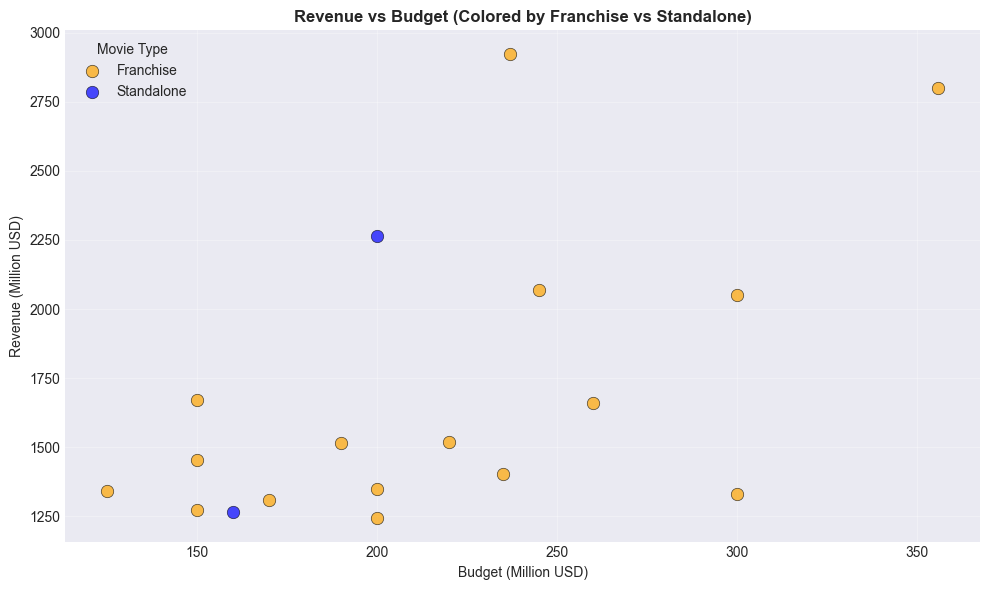

In [55]:


# Extract year
df_final['release_year'] = pd.to_datetime(df_final['release_date']).dt.year

# Create franchise indicator
df_final['Movie Type'] = df_final['collection_name'].notna().map({True: 'Franchise', False: 'Standalone'})

# Plot with color by franchise
plt.figure(figsize=(10, 6))
colors = {'Franchise': 'orange', 'Standalone': 'blue'}

for movie_type, group in df_final.groupby('Movie Type'):
    plt.scatter(group['budget_musd'], group['revenue_musd'], 
                label=movie_type, alpha=0.7, s=80, c=colors[movie_type], edgecolors='black', linewidth=0.5)
                

plt.xlabel('Budget (Million USD)')
plt.ylabel('Revenue (Million USD)')
plt.title('Revenue vs Budget (Colored by Franchise vs Standalone)', fontweight='bold')
plt.grid(True, alpha=0.3)

# This is the key line → adds the legend!
plt.legend(title='Movie Type')

plt.tight_layout()
plt.show()


📊 Plot 2: ROI by Genre


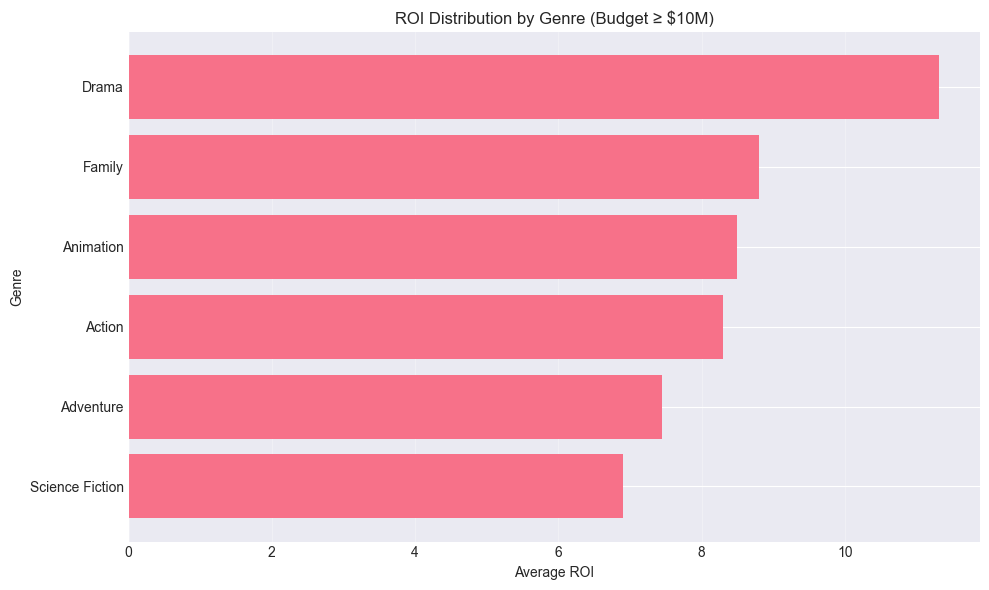

In [46]:
# ========================================
# 2. ROI DISTRIBUTION BY GENRE
# ========================================
print("\n📊 Plot 2: ROI by Genre")

# Get primary genre for each movie
df_final['primary_genre'] = df_final['genres'].str.split('|').str[0]

# Filter for valid ROI (budget >= 10M)
df_roi = df_final[(df_final['budget_musd'] >= 10) & (df_final['roi'].notna())]

# Get top 6 genres
top_genres = df_roi['primary_genre'].value_counts().head(6).index
df_genre = df_roi[df_roi['primary_genre'].isin(top_genres)]

# Calculate mean ROI per genre
genre_roi = df_genre.groupby('primary_genre')['roi'].mean().sort_values()

plt.figure(figsize=(10, 6))
plt.barh(genre_roi.index, genre_roi.values)
plt.xlabel('Average ROI')
plt.ylabel('Genre')
plt.title('ROI Distribution by Genre (Budget ≥ $10M)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



Plot 3: Popularity vs Rating


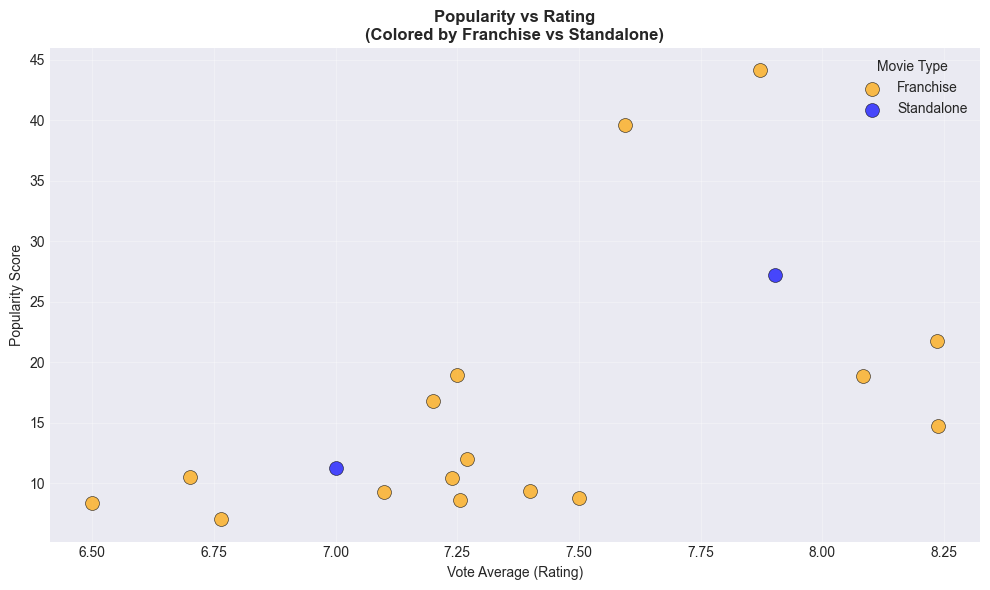

In [57]:
# ========================================
# 3. POPULARITY vs RATING
# ========================================
print("\nPlot 3: Popularity vs Rating")

# Filter movies with at least 10 votes
df_valid = df_final[df_final['vote_count'] >= 10].copy()

# Create Movie Type column (Franchise or Standalone)
df_valid['Movie Type'] = df_valid['collection_name'].notna().map({True: 'Franchise', False: 'Standalone'})

plt.figure(figsize=(10, 6))
colors = {'Franchise': 'orange', 'Standalone': 'blue'}

for movie_type, group in df_valid.groupby('Movie Type'):
    plt.scatter(group['vote_average'], group['popularity'], 
                label=movie_type, alpha=0.7, s=100, c=colors[movie_type], 
                edgecolors='black', linewidth=0.5)

plt.xlabel('Vote Average (Rating)')
plt.ylabel('Popularity Score')
plt.title('Popularity vs Rating\n(Colored by Franchise vs Standalone)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(title='Movie Type')
plt.tight_layout()
plt.show()


📊 Plot 4: Yearly Box Office Trends


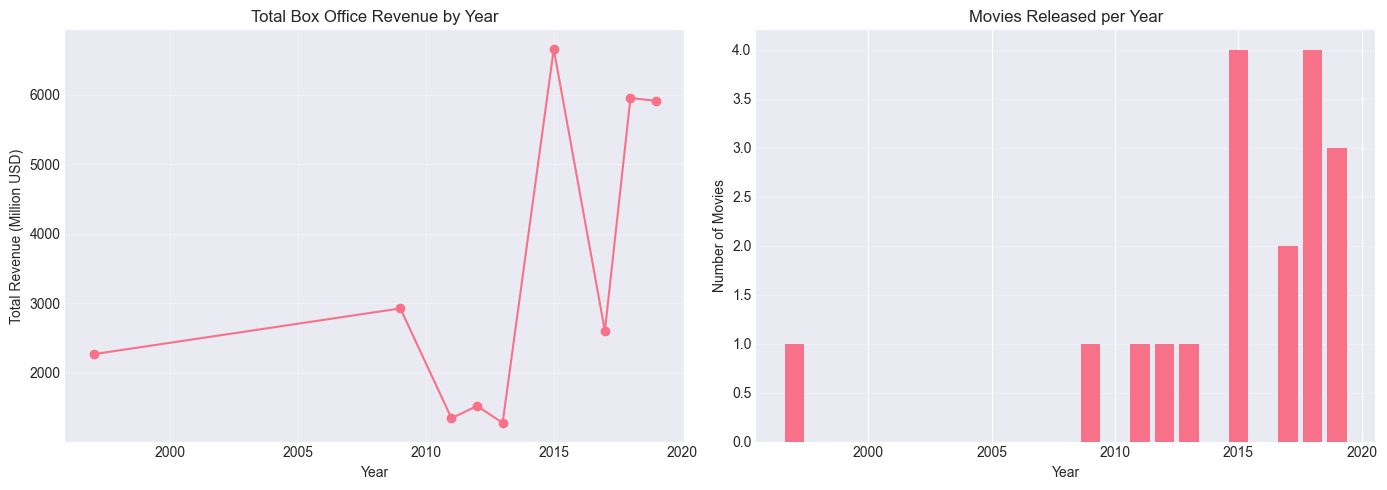

In [52]:
# ========================================
# 4. YEARLY TRENDS IN BOX OFFICE
# ========================================
print("\n📊 Plot 4: Yearly Box Office Trends")

# Group by year
yearly = df_final.groupby('release_year').agg({
    'revenue_musd': 'sum',
    'budget_musd': 'mean',
    'title': 'count'
}).reset_index()

yearly.columns = ['year', 'total_revenue', 'mean_budget', 'movie_count']

# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Total Revenue per Year
ax1.plot(yearly['year'], yearly['total_revenue'], marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Revenue (Million USD)')
ax1.set_title('Total Box Office Revenue by Year')
ax1.grid(True, alpha=0.3)

# Plot 2: Number of Movies per Year
ax2.bar(yearly['year'], yearly['movie_count'])
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Movies')
ax2.set_title('Movies Released per Year')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


📊 Plot 5: Franchise vs Standalone


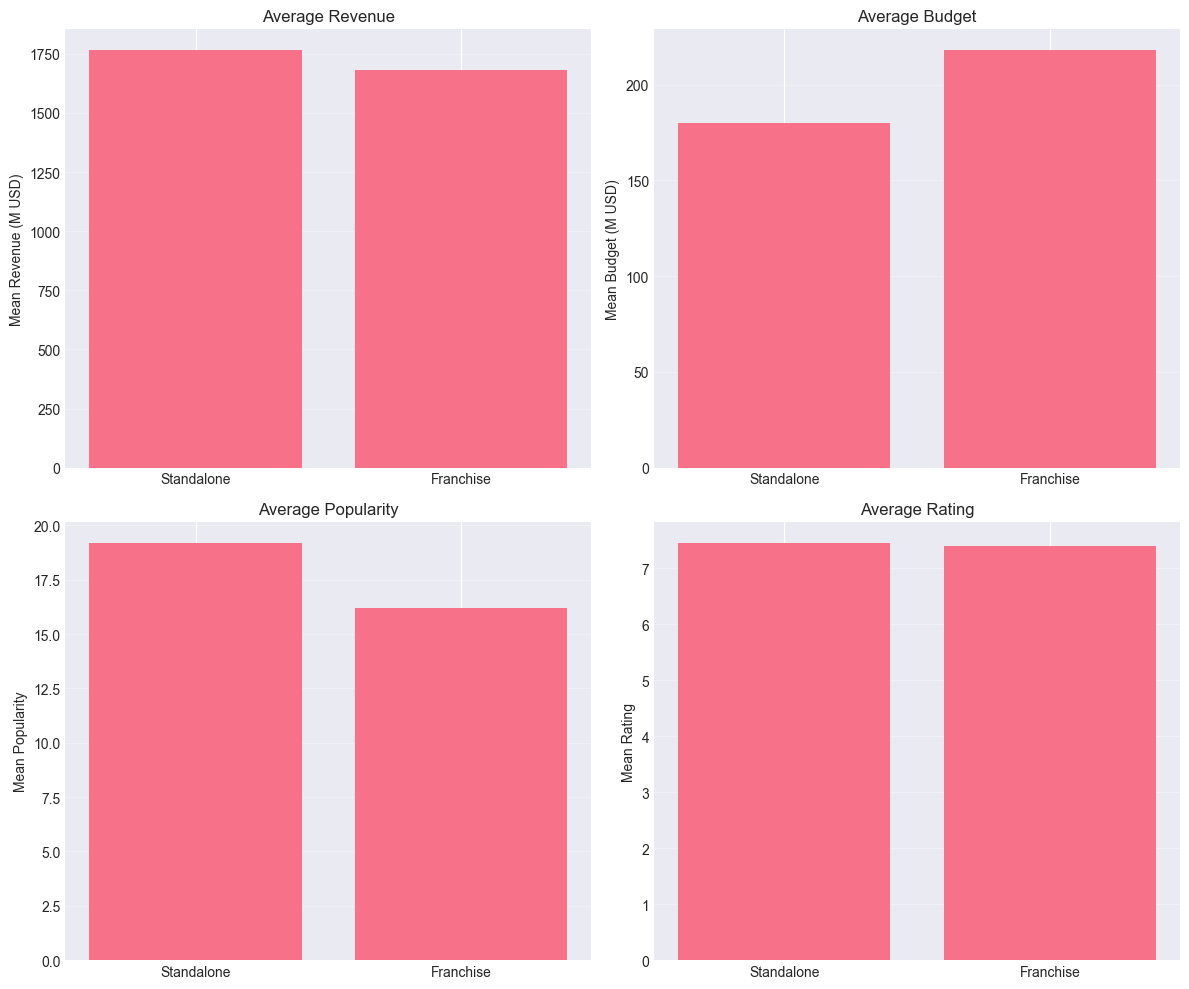

In [58]:
# ========================================
# 5. FRANCHISE vs STANDALONE COMPARISON
# ========================================
print("\n📊 Plot 5: Franchise vs Standalone")

# Calculate comparison metrics
comparison = df_final.groupby('is_franchise').agg({
    'revenue_musd': 'mean',
    'budget_musd': 'mean',
    'popularity': 'mean',
    'vote_average': 'mean',
    'title': 'count'
}).reset_index()

comparison['type'] = comparison['is_franchise'].map({True: 'Franchise', False: 'Standalone'})

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Mean Revenue
axes[0, 0].bar(comparison['type'], comparison['revenue_musd'])
axes[0, 0].set_ylabel('Mean Revenue (M USD)')
axes[0, 0].set_title('Average Revenue')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Mean Budget
axes[0, 1].bar(comparison['type'], comparison['budget_musd'])
axes[0, 1].set_ylabel('Mean Budget (M USD)')
axes[0, 1].set_title('Average Budget')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Mean Popularity
axes[1, 0].bar(comparison['type'], comparison['popularity'])
axes[1, 0].set_ylabel('Mean Popularity')
axes[1, 0].set_title('Average Popularity')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Mean Rating
axes[1, 1].bar(comparison['type'], comparison['vote_average'])
axes[1, 1].set_ylabel('Mean Rating')
axes[1, 1].set_title('Average Rating')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()